## Baseline CNN

Here is a first run of the CNN on the dataset. It includes 14 different classes, the 13 different street light types and a class for images with no street light shown.

### Import Libraries

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


### Mount the google drive

In [2]:
!pip install colab-env -qU
import colab_env

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
image_path = '/content/gdrive/MyDrive/streetlights_datasets/images_firstrun_sort'

In [7]:
data_dir = pathlib.Path(image_path).joinpath('ENCL_light')

In [8]:
data_dir

PosixPath('/content/gdrive/MyDrive/streetlights_datasets/images_firstrun_sort/ENCL_light')

In [9]:
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

1301


In [13]:
ENCL_light = list(data_dir.glob('*.jpg'))

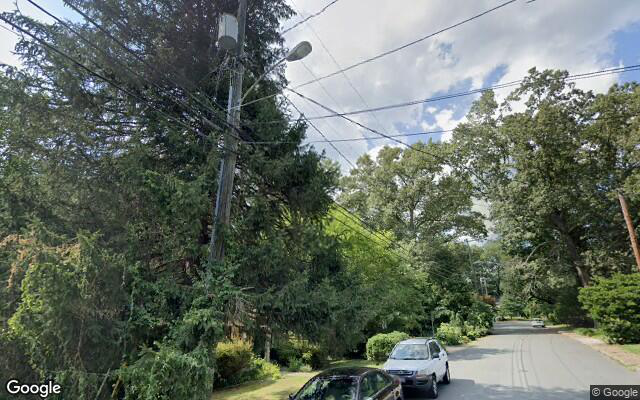

In [18]:
PIL.Image.open(str(ENCL_light[7]))

### Split the data into a training and validation set

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path, labels='inferred', label_mode="categorical",
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=42, validation_split=0.2, subset="training",
    interpolation='bilinear', follow_links=False
)

Found 3557 files belonging to 14 classes.
Using 2846 files for training.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_path, labels='inferred', label_mode="categorical",
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=42, validation_split=0.2, subset="validation",
    interpolation='bilinear', follow_links=False
)

Found 3557 files belonging to 14 classes.
Using 711 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)

['AOBA_light', 'CLSU_light', 'COBR_light', 'COLN_light', 'COXX_light', 'CTMP_light', 'DIR_light', 'ENCL_light', 'ENFL_light', 'OPEN_light', 'RECT_light', 'TRAD_light', 'ULFL_light', 'pole_nolight']


### Configure the dataset for performance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [28]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Create and Compile Model

In [43]:
num_classes = 14

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train Model

In [44]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
89/89 [==============================] - 174s 2s/step - loss: 1.3768 - accuracy: 0.4697 - val_loss: 1.1623 - val_accuracy: 0.5218
Epoch 2/10
89/89 [==============================] - 171s 2s/step - loss: 1.1578 - accuracy: 0.5157 - val_loss: 1.2072 - val_accuracy: 0.5218
Epoch 3/10
89/89 [==============================] - 174s 2s/step - loss: 1.0882 - accuracy: 0.5547 - val_loss: 1.1532 - val_accuracy: 0.5035
Epoch 4/10
89/89 [==============================] - 172s 2s/step - loss: 1.1155 - accuracy: 0.5330 - val_loss: 1.1633 - val_accuracy: 0.5218
Epoch 5/10
89/89 [==============================] - 171s 2s/step - loss: 1.0890 - accuracy: 0.5409 - val_loss: 1.1653 - val_accuracy: 0.4740
Epoch 6/10
89/89 [==============================] - 172s 2s/step - loss: 1.1069 - accuracy: 0.5378 - val_loss: 1.1656 - val_accuracy: 0.5316
Epoch 7/10
89/89 [==============================] - 171s 2s/step - loss: 1.0615 - accuracy: 0.5715 - val_loss: 1.1555 - val_accuracy: 0.5457
Epoch 8/10
89

### Visualize Results

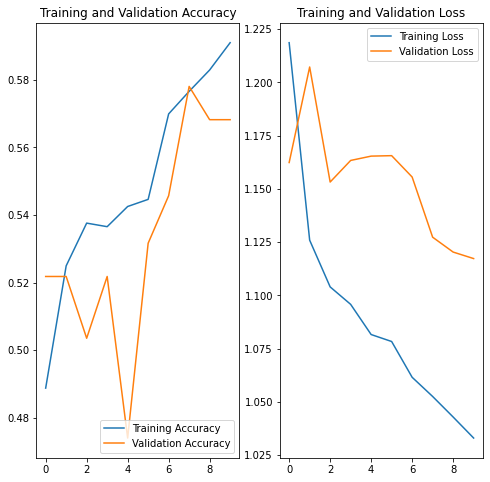

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
class_pred = model.predict_classes(val_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [72]:
from collections import Counter

In [73]:
Counter(class_pred.tolist())

Counter({7: 314, 13: 397})

In [59]:
[class_names[7], class_names[13]]

['ENCL_light', 'pole_nolight']

The CNN only predicts 'ENCL_light' or 'pole_nolight', which are the most common image types in our dataset. 